In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pathlib
project_path = pathlib.Path('.').absolute().parent
python_path = project_path/'src'
os.sys.path.insert(1, str(python_path))

In [3]:
from dotmap import DotMap
import pybullet
    
import numpy as np
import matplotlib.pyplot as plt
import pinocchio as pin

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [5]:
from cto.params import get_default_params, update_params
from robot_properties_nyu_finger.config import NYUFingerDoubleConfig0, NYUFingerDoubleConfig1
from cto.envs.fingers import FingerDoubleAndBox
from cto.miqp.problems import MIQP

object_urdf = str(python_path/'cto'/'envs'/'resources'/'box.urdf')
robot_config = [NYUFingerDoubleConfig0(), NYUFingerDoubleConfig1()]
params = get_default_params(object_urdf, robot_config, MIQP=True)

In [7]:
# slide
z = params.box_com_height
desired_poses = [np.array([0, 0.0, z, 0, 0, 0]), 
                 np.array([0, 0.1, z, 0, 0, 0])]
params = update_params(params, desired_poses)

In [ ]:
# # lift
# z = params.box_com_height
# desired_poses = [np.array([0, 0.0, z, 0, 0, 0]),
#                  np.array([0, 0.0, z + 0.1, 0, 0, 0])]
# params = update_params(params, desired_poses)

In [8]:
# # rotate
# z = params.box_com_height
# desired_poses = [np.array([0, 0.0, z, 0, 0, 0]), 
#                  np.array([0, 0.0, z, 0, 0, np.pi/2])]
# params = update_params(params, desired_poses)

In [9]:
# # rotate twice
# z = params.box_com_height
# desired_poses = [np.array([0, 0.0, z, 0, 0, 0]), 
#                  np.array([0, 0.0, z, 0, 0, np.pi/2]),
#                  np.array([0, 0.0, z, 0, 0, np.pi])]
# params = update_params(params, desired_poses)

In [10]:
# # pivot about the y-axis by 30 degree
# p = 0.05
# rot = 30 * np.pi/ 180
# th = rot + 45 * np.pi / 180
# dx = p - np.cos(th) * np.sqrt(2) * p
# dz = np.sin(th) * np.sqrt(2) * p - p

# desired_poses = [np.array([0,  0.,  0.1, 0, 0, 0]),
#                  np.array([dx, 0., 0.1 + dz, 0, rot, 0])]
# params = update_params(params, desired_poses)

In [11]:
pose_init = pin.SE3ToXYZQUAT(params.desired_poses[0])
box_pos = pose_init[:3]
box_orn = pose_init[3:]
env = FingerDoubleAndBox(params, box_pos, box_orn, server=pybullet.DIRECT)

In [12]:
miqp = MIQP(params)
miqp.setup()
# increase the number of feasible solutions can reduce the force error but will be slow
sol = miqp.solve(nsol=10) 

## Compare the solution with the desired force/torque

In [13]:
total_force = np.zeros((len(sol.forces), 3))
total_torque = np.zeros((len(sol.forces), 3))

for n in range(len(sol.forces)):
    total_force[n] = np.sum(sol.forces[n], axis=0)
    total_torque[n] = np.sum(np.cross(sol.locations[n], sol.forces[n]), axis=0)

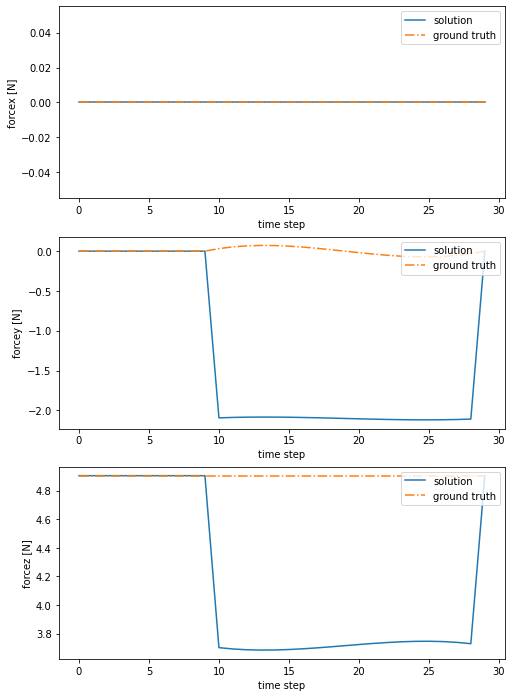

In [14]:
f, ax = plt.subplots(3, 1,figsize=(8, 12))
axis_label = ['x','y','z']
for i in range(3):
    ax[i].plot(total_force[:, i], label="solution")
    ax[i].plot(params.traj_desired.total_force[:, i], ls='-.', label="ground truth")
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("force" + axis_label[i]+' [N]')
    ax[i].legend(loc='upper right')

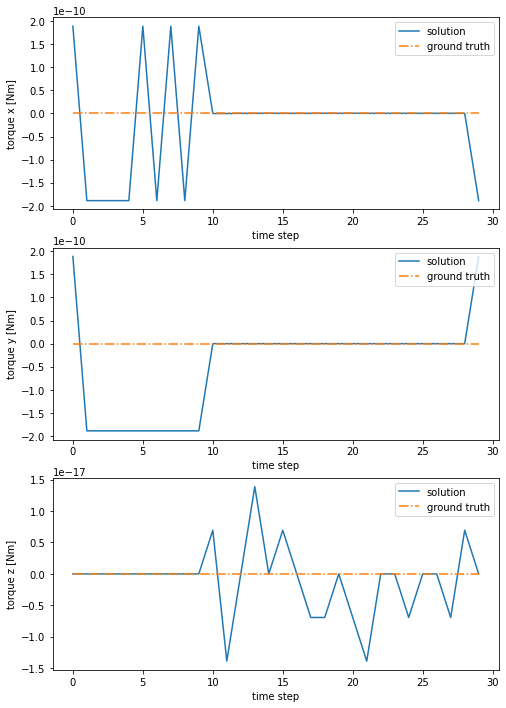

In [15]:
f, ax = plt.subplots(3, 1,figsize=(8, 12))
axis_label = ['x','y','z']
for i in range(3):
    ax[i].plot(total_torque[:, i], label="solution")
    ax[i].plot(params.traj_desired.total_torque[:, i], ls='-.', label="ground truth")
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("torque " + axis_label[i]+' [Nm]')
    ax[i].legend(loc='upper right')

## Visualize the plan

In [16]:
from cto.mcts.problems import integrate_solution
traj_viz = integrate_solution(sol, params)
box = params.box
viz = pin.visualize.MeshcatVisualizer(
    box.wrapper.model, box.wrapper.collision_model, box.wrapper.visual_model
)
viz.initViewer(open=False)
viz.loadViewerModel()
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [17]:
from cto.utils.meshcat import Arrow

sleep_factor = 5

arrows = []
arrows.append(Arrow(viz.viewer, "force0", length_scale=0.08, color=0x0000ff))
arrows.append(Arrow(viz.viewer, "force1", length_scale=0.08, color=0x00ff00))
arrows.append(Arrow(viz.viewer, "force2", length_scale=0.08, color=0xff0000))
arrows.append(Arrow(viz.viewer, "force3", length_scale=0.08, color=0xff0000))
arrows.append(Arrow(viz.viewer, "force4", length_scale=0.08, color=0xff0000))
arrows.append(Arrow(viz.viewer, "force5", length_scale=0.08, color=0xff0000))

for n in range(params.horizon):
    viz.display(traj_viz.q[n])
    q = traj_viz.q
    curr_pose = pin.XYZQUATToSE3(q[n])
    p = curr_pose.translation
    R = curr_pose.rotation
    for i in range(len(arrows)):
        if i < len(sol.forces[n]):
            force_world = R @ sol.forces[n][i]
            location_world = p + R @ sol.locations[n][i]
            arrows[i].anchor_as_vector(location_world, force_world)
        else:
            arrows[i].anchor_as_vector([0, 0, 0], [0, 0, 0])
    time.sleep(sleep_factor * params.dt)

/home/hz/Research/plan_dexterity/src/cto/utils/meshcat.py:55: RuntimeWarning: invalid value encountered in true_divide
  self.set_direction(np.array(vector)/np.linalg.norm(vector), False)
